# MLFLOW Example

This notebook is the same as the original 

**Assumptions** 
1. MLFlow is [installed in Python environment](https://mlflow.org/docs/latest/getting-started/intro-quickstart/index.html#step-1-get-mlflow)
2. MLFlow is running before running the notebook below: use the command `mlflow ui` in a terminal
3. Data used for this notebook is in the `data_prior` directory

Once all the above assumptions are satisfied, run the notebook below and go to `localhost:5000` in your web browser to see the MLFLOW UI.

# **Tutorial** - Time Series Prediction of Snow Water Equivalent (SWE) Using LSTM in PyTorch


First, we import all the necessary libraries such as `torch`, `numpy`, `pandas`, and others for data preprocessing, model building, and evaluation. These libraries are key for handling data, neural networks, and visualization.

In [1]:
import os
import time
import gdown
import torch
import warnings
import mlflow
import mlflow.pytorch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.utils.data as data

from torch import nn
from tqdm.autonotebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings('ignore')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32

/var/folders/t2/pqftybhj5yb97x71hbzfhh500000gn/T/ipykernel_14152/914508400.py:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Create a new MLflow Experiment called "LSTM"
mlflow.set_experiment("LSTM")

2025/01/24 10:14:02 INFO mlflow.tracking.fluent: Experiment with name 'LSTM' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/393032629103528079', creation_time=1737742442905, experiment_id='393032629103528079', last_update_time=1737742442905, lifecycle_stage='active', name='LSTM', tags={}>

## **Downloading zip files onto the drive**

In [ ]:
url = "https://drive.google.com/drive/folders/1YWvq4F1Y0mrZh5hAkBjaINEZeAFCBsgD?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/Cloud Implementation Tutorial/wrf-skagit-HUC10-mean.zip',
 '/content/Cloud Implementation Tutorial/wus-sr-skagit-HUC10-mean-swe.zip']

## **Unzipping Data Files**

Here, we unzip the datasets required for the analysis

In [ ]:
!unzip '/content/Cloud Implementation Tutorial/wrf-skagit-HUC10-mean.zip' -d '/content/wrf-skagit-HUC10-mean'
!unzip '/content/Cloud Implementation Tutorial/wus-sr-skagit-HUC10-mean-swe.zip' -d '/content/wus-sr-skagit-HUC10-mean-swe'

Archive:  /content/Cloud Implementation Tutorial/wrf-skagit-HUC10-mean.zip
  inflating: /content/wrf-skagit-HUC10-mean/wrf-skagit-1711000504-mean.csv  
  inflating: /content/wrf-skagit-HUC10-mean/wrf-skagit-1711000505-mean.csv  
  inflating: /content/wrf-skagit-HUC10-mean/wrf-skagit-1711000506-mean.csv  
  inflating: /content/wrf-skagit-HUC10-mean/wrf-skagit-1711000507-mean.csv  
  inflating: /content/wrf-skagit-HUC10-mean/wrf-skagit-1711000508-mean.csv  
  inflating: /content/wrf-skagit-HUC10-mean/wrf-skagit-1711000509-mean.csv  
  inflating: /content/wrf-skagit-HUC10-mean/wrf-skagit-1711000511-mean.csv  
Archive:  /content/Cloud Implementation Tutorial/wus-sr-skagit-HUC10-mean-swe.zip
  inflating: /content/wus-sr-skagit-HUC10-mean-swe/wus-sr-skagit-1711000504-mean-swe.csv  
  inflating: /content/wus-sr-skagit-HUC10-mean-swe/wus-sr-skagit-1711000505-mean-swe.csv  
  inflating: /content/wus-sr-skagit-HUC10-mean-swe/wus-sr-skagit-1711000506-mean-swe.csv  
  inflating: /content/wus-sr-sk

In [3]:
# This function normalizes the data using the Z-score formula, which helps to standardize the features

def z_score_normalize(df):
	normalized_df = df.copy()

	for column in df.columns:
		column_mean = df[column].mean()
		column_std = df[column].std()
		normalized_df[column] = (df[column] - column_mean) / column_std

	return normalized_df

# This function filters and merges two datasets (WRF and WUS) based on date ranges and resamples the data. It saves the filtered data as a new CSV:

def filter_and_merge_data(wrf_file, wus_file, filter_start_date, filter_end_date, filtered_data_start_data, filtered_data_end_data):
    # read WRF data
    #file_number = wrf_file.split('-')[5]
    wrf = pd.read_csv(wrf_file)
    wrf['time'] = pd.to_datetime(wrf['time'])
    wrf.set_index('time', inplace=True)

    # Filter based on time index range
    wrf_filtered = wrf.loc[(wrf.index > filter_start_date) & (wrf.index < filter_end_date)]

    # Resampling the data
    wrf_resampled = wrf_filtered.resample('D').mean()

    # read WUS data
    wus = pd.read_csv(wus_file)
    wus['time'] = pd.to_datetime(wus['time'])
    wus.set_index('time', inplace=True)

    # Filter based on time index range
    wus_filtered = wus.loc[wus.index < filter_end_date]

    # Merging the data
    data = pd.merge(wrf_resampled, wus_filtered, left_index=True, right_index=True, how='inner')
    data = data[['lw', 'precip', 'rh', 'tair', 'wind', 'mean']]
    data.rename(columns={'mean': 'SWE_Post'}, inplace=True)

    # Save the merged data to a new CSV file
    try:
        data.to_csv(f'filtered_csv_1.csv')
        print('File Saved !!')
    except:
        print('File save failed !!')

    # Filter the final data based on the date range
    filtered_data = data.loc[(data.index >= filtered_data_start_data) & (data.index <= filtered_data_end_data)]

    return data, filtered_data

## **Creating Dataset for Time Series Prediction**

This function transforms time-series data into a format suitable for model training. It uses the lookback parameter to determine how many previous time steps to consider as input features

In [4]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A pandas DataFrame of time series data
        lookback: Size of window for prediction
    """
    X, y = [], []
    print(dataset)
    for i in range(len(dataset) - lookback):
        feature = dataset.iloc[i:(i + lookback), :5].values  # Select first two columns
        target = dataset.iloc[i + lookback, 5:].values  # Select the last column as target
        X.append(feature)
        y.append(target)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

## **Snow Model (LSTM Neural Network)**

This is a simple LSTM-based neural network model designed for predicting SWE_Post values. The model uses one LSTM layer followed by a linear layer and LeakyReLU activation.



In [5]:
class SnowModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_class, num_layers, dropout):
        super(SnowModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, dropout=self.dropout, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_class)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        device = x.device
        hidden_states = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        cell_states = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm1(x, (hidden_states, cell_states))
        out = self.linear(out[:, -1, :])
        out = self.leaky_relu(out)
        return out

## **Training the Model**

This function trains the model on the training data for a specified number of epochs and batch size. It also prints the Root Mean Square Error (RMSE) every 10 epochs.

In [68]:
def train_model(model, optimizer, loss_fn, X_train, y_train, n_epochs, batch_size):
    loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
    epoch_losses = []

    for epoch in range(n_epochs):
        print(f'THIS IS EPOCH NUMBER: {epoch}')
        epoch_loss = 0.0
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
		# Validation
        #if epoch % 10 != 0:
        #    continue

        model.eval()

        with torch.no_grad():
            y_pred = model(X_train)
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            print(f"HELLLLLLLLLLLLL Epoch {epoch}: train RMSE {train_rmse:.4f}")

        epoch_losses.append(epoch_loss / len(loader))
        print(f'LOSS: {epoch_loss}')

        # Location where a form of loss for MLFLOW to track
        mlflow.log_metric("loss", epoch_loss, step=epoch)

    return epoch_losses

## **Predicting and Plotting Results**

This function predicts values on the training and test datasets and visualizes the predictions compared to the actual SWE_Post values.



In [63]:
def predict(data, model, X_train,X_test, lookback, train_size):
	data = data.astype(object)

	with torch.no_grad():
		train_plot = np.full_like(data['SWE_Post'].values, np.nan, dtype=float)
		y_pred = model(X_train)
		print(y_pred.shape)
		y_pred_new = y_pred[:, -1].unsqueeze(1)
		print(y_pred_new.shape)
		print(type(lookback),type(train_size))
		train_plot[lookback:train_size] = y_pred_new.numpy().flatten()

		# shift test predictions for plotting
		test_plot = np.full_like(data['SWE_Post'].values, np.nan, dtype=float)
		test_plot[train_size+lookback:len(data)] = model(X_test)[:,  -1].unsqueeze(1).numpy().flatten()

	# plot
	plt.figure(figsize=(12,  6))
	plt.plot(data.index, data['SWE_Post'], c='b', label='Actual')
	plt.plot(data.index, train_plot, c='r', label='Train Predictions')
	plt.plot(data.index[train_size+lookback:], test_plot[train_size+lookback:], c='g', label='Test Predictions')
	plt.legend()
	plt.xlabel('Date')
	plt.ylabel('SWE_Post')
	plt.title('SWE_Post Predictions')
	plt.show()

## **Model Evaluation**
This function evaluates the model using standard metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared score (R2).

In [64]:
def evaluate_metrics(model, X_train, y_train, X_test, y_test):

	with torch.no_grad():
		y_train_pred = model(X_train)
		y_test_pred = model(X_test)

	train_mse = mean_squared_error(y_train.numpy(), y_train_pred.numpy())
	test_mse = mean_squared_error(y_test.numpy(), y_test_pred.numpy())
	train_mae = mean_absolute_error(y_train.numpy(), y_train_pred.numpy())
	test_mae = mean_absolute_error(y_test.numpy(), y_test_pred.numpy())
	train_r2 = r2_score(y_train.numpy(), y_train_pred.numpy())
	test_r2 = r2_score(y_test.numpy(), y_test_pred.numpy())

	return  [train_mse, test_mse, train_mae, test_mae, train_r2, test_r2]

In [65]:
def  get_csv_filenames(directory):
  """ Returns a sorted list of CSV filenames from the given directory."""
  return  sorted([f for f in os.listdir(directory)  if f.endswith('.csv')])

# MLFLOW
Below MLFLOW is used. Notice around line 29 the following `with mlflow.start_run():`. This does two things:
1. Connects to and tells MLFLOW that a new model training run has started. This will look like a new random name under an experiment in MLFLOW.
2. Since the `with` context is being used, you don't need to worry about closing the connection to MLFLOW, that is handled for you as long as all the relevent code is ran within the context.
3. Towards the end of the cell below, the `mlflow.log_param` function is being used to keep track of a parameter for the experiment. These are going to be things that are static for a given training cycle.

## **Running the Pipeline**

This section retrieves the filenames from the dataset directories, filters and merges data, and finally trains and evaluates the model.

 Files: ./Verify_Pipeline/data_prior/wrf-skagit-1711000504-mean.csv and ./Verify_Pipeline/data_prior/wus-sr-skagit-1711000504-mean-swe.csv
File Saved !!
lw          0
precip      0
rh          0
tair        0
wind        0
SWE_Post    0
dtype: int64
Empty DataFrame
Columns: [lw, precip, rh, tair, wind, SWE_Post]
Index: []
lw          0
precip      0
rh          0
tair        0
wind        0
SWE_Post    0
dtype: int64

Lookback: 180
                    lw    precip         rh      tair      wind  SWE_Post
time                                                                     
1984-10-01  259.367226  0.000000  60.281798  6.411905  2.955417  0.000000
1984-10-02  265.004854  0.000000  64.754563  6.803479  2.311583  0.000000
1984-10-03  290.302240  0.000162  68.626458  7.404792  2.516750  0.000000
1984-10-04  297.667042  0.000525  65.450146  8.842219  4.883500  0.000000
1984-10-05  283.994729  0.000256  72.273552  4.537219  2.305833  0.000046
...                ...       ...        ...   

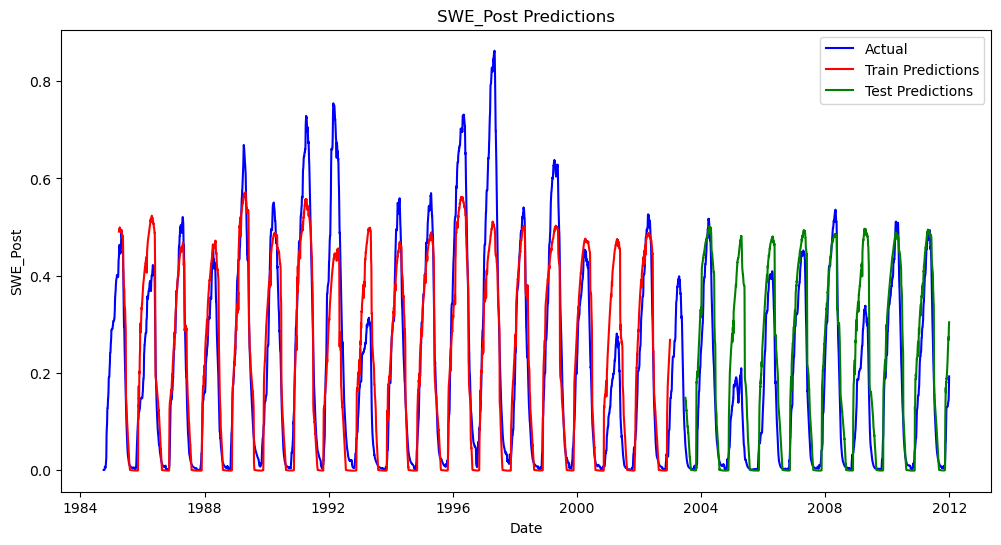

[0.0085858535, 0.0091676535, 0.064922675, 0.06774572, 0.8183410167694092, 0.663285493850708]


2025/01/24 10:45:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.008586       55.841338
1       180  snotel   test_mse  0.009168       55.841338
2       180  snotel  train_mae  0.064923       55.841338
3       180  snotel   test_mae  0.067746       55.841338
4       180  snotel   train_r2  0.818341       55.841338
5       180  snotel    test_r2  0.663285       55.841338
🏃 View run dazzling-gnat-79 at: http://127.0.0.1:5000/#/experiments/393032629103528079/runs/aa9baa6cd7fb4e2db438cc010dee3486
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/393032629103528079


In [66]:
# Define the hyperparameters
input_size=5
hidden_size=2**6
num_class=1
num_layers=1
dropout = 0.5

learning_rate = 1e-3 #3e-3
n_epochs = 5
train_size_fraction = 0.67

lookback_values =  [180]
def get_csv_filenames(directory):
    """
    Returns a sorted list of CSV filenames from the given directory.
    """
    return sorted([f for f in os.listdir(directory) if f.endswith('.csv')])

# Define the directories containing the CSV files
directory1 = 'wrf-skagit-HUC10-mean'
directory2 = 'wus-sr-skagit-HUC10-mean-swe'

# Get CSV filenames from both directories
#filenames1 = get_csv_filenames(directory1)
#filenames2 = get_csv_filenames(directory2)

# Ensure that both directories have the same number of files and their names match up correctly
#assert len(filenames1) == len(filenames2), "Mismatch in the number of CSV files between the directories."
with mlflow.start_run():
    model_snotel = SnowModel(input_size, hidden_size, num_class, num_layers, dropout)
    optimizer_snotel = optim.Adam(model_snotel.parameters())
    loss_fn_snotel = nn.MSELoss()
    
    # List the files together, assuming they are related in chronological order and should be compared one-to-one
    #for file1, file2 in zip(filenames1, filenames2):
    wrf_file = "./Verify_Pipeline/data_prior/wrf-skagit-1711000504-mean.csv" #os.path.join(directory1, file1)
    wus_file = "./Verify_Pipeline/data_prior/wus-sr-skagit-1711000504-mean-swe.csv" #os.path.join(directory2, file2)
    print(f" Files: {wrf_file} and {wus_file}")
    
    # Example usage of filter_and_merge_data
    filter_start_date = '1984-10-01'
    filter_end_date = '2011-12-31'
    filtered_data_start_data = '2005-01-01'
    filtered_data_end_data = '2007-12-31'
    
    # Assuming filter_and_merge_data is a function you have defined elsewhere
    data, filtered_data = filter_and_merge_data(wrf_file, wus_file, filter_start_date, filter_end_date, filtered_data_start_data, filtered_data_end_data)
    
    # train-test split for time series
    
    print(data.isna().sum())
    data = data.fillna(method='bfill')
    
    nan_rows = data[data.isna().any(axis=1)]
    print(nan_rows)
    
    print(data.isna().sum())
    train_size_main = int(len(data) * 0.67)
    test_size_main = len(data) - train_size_main
    train_main, test_main = data[:train_size_main], data[train_size_main:]

    # train-test split for time series
    test_size_filtered = int(len(filtered_data))
    test_filtered = filtered_data[:train_size_main]
    
    
    # Usage example
    lookback_values =  [180]
    results = []
    
    for lookback in lookback_values:
        print(f"\nLookback: {lookback}")
        start_time = time.time()
    
        # Snotel dataset
        X_train_snotel, y_train_snotel = create_dataset(train_main, lookback)
        X_test_snotel, y_test_snotel = create_dataset(test_main, lookback)
    
    
        epoch_losses = train_model(model_snotel, optimizer_snotel, loss_fn_snotel, X_train_snotel, y_train_snotel, n_epochs=n_epochs, batch_size=8)
        predict(data,model_snotel,  X_train_snotel,X_test_snotel, lookback, train_size_main)
        snotel_metrics = evaluate_metrics(model_snotel, X_train_snotel, y_train_snotel, X_test_snotel, y_test_snotel)
        print(snotel_metrics)
        elapsed_time = time.time() - start_time
    
        results.append([lookback, 'snotel', 'train_mse', snotel_metrics[0], elapsed_time])
        results.append([lookback, 'snotel', 'test_mse', snotel_metrics[1], elapsed_time])
        results.append([lookback, 'snotel', 'train_mae', snotel_metrics[2], elapsed_time])
        results.append([lookback, 'snotel', 'test_mae', snotel_metrics[3], elapsed_time])
        results.append([lookback, 'snotel', 'train_r2', snotel_metrics[4], elapsed_time])
        results.append([lookback, 'snotel', 'test_r2', snotel_metrics[5], elapsed_time])

    # Log parameteres with MLFLOW
    mlflow.log_param("input_dim", input_size)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("dropout", dropout)
    mlflow.log_param("n_epochs", n_epochs)
    mlflow.log_param("lookback", lookback)
    mlflow.pytorch.log_model(model_snotel, f"model_snotel_lookback_{lookback}")
    
    
    # Create a DataFrame for the results
    df_results = pd.DataFrame(results, columns=['Lookback', 'Dataset', 'Metric', 'Value', 'Time Taken (s)'])
    
    # Print the DataFrame
    print(df_results)

# MLFLOW AFTER TRAINING

When a model has successfully completed training with MLFLOW, hyperlinks (like the one seen directly above this cell) should appear. These hyperlinks should open up a browser to the MLFLOW UI when clicked.

In [67]:
epoch_losses

[0.013014814216036662,
 0.010735907128909556,
 0.010191224648791759,
 0.00977488401970044,
 0.008585204764567292]